In [2]:
import numpy as np
import nimblephysics as nimble
from typing import List

# Load subject from B3D file
b3d_path = "data/AddBiomechanicsDataset./test/With_Arm/Han2023_Formatted_With_Arm/s003_split4/s003_split4.b3d" 
subject = nimble.biomechanics.SubjectOnDisk(b3d_path)

# Load frames from a trial
trial = 1
frames = subject.readFrames(
    trial=trial,
    startFrame=0,
    numFramesToRead=subject.getTrialLength(trial),
    includeProcessingPasses=True  # This is the correct parameter if you need processing passes
)

num_force_plates = subject.getNumForcePlates(trial=trial)
cop = np.zeros((len(frames), num_force_plates, 3))  # Center of pressure
grf = np.zeros((len(frames), num_force_plates, 3))  # Ground reaction forces
num_markers = len(frames[0].markerObservations)
marker_clouds = np.zeros((len(frames), num_markers, 3))
for i, frame in enumerate(frames):
    cop[i] = frame.rawForcePlateCenterOfPressures
    grf[i] = frame.rawForcePlateForces
    observed_markers = [pos[1] for pos in frame.markerObservations]
    num_observed = len(observed_markers)
    if num_observed > 0:
        marker_clouds[i, :num_observed, :] = np.array(observed_markers)

cop = cop[:, :, [0, 2, 1]]
grf = grf[:, :, [0, 2, 1]]
marker_clouds = marker_clouds[:, :, [0, 2, 1]]

subject.getMassKg()

53.07

In [3]:
cop.shape # (framecount, num_force_plates, 3)
grf.shape # (framecount, num_force_plates, 3)


(2000, 5, 3)

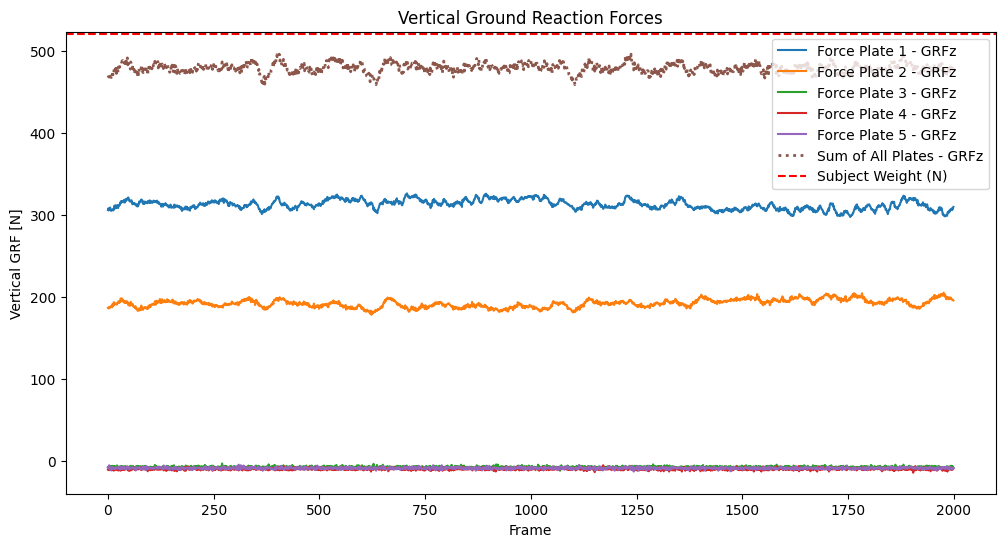

In [4]:
import matplotlib.pyplot as plt

# Plot the vertical GRF (z-component) for both force plates
plt.figure(figsize=(12, 6))
for plate in range(grf.shape[1]):
    plt.plot(grf[:, plate, 2], label=f'Force Plate {plate+1} - GRFz')
plt.plot(np.sum(grf[:, :, 2], axis=1), label='Sum of All Plates - GRFz', linewidth=2, linestyle=':')
plt.axhline(subject.getMassKg() * 9.81, color='red', linestyle='--', label='Subject Weight (N)')
plt.xlabel('Frame')
plt.ylabel('Vertical GRF [N]')
plt.title('Vertical Ground Reaction Forces')
plt.legend()
plt.show()

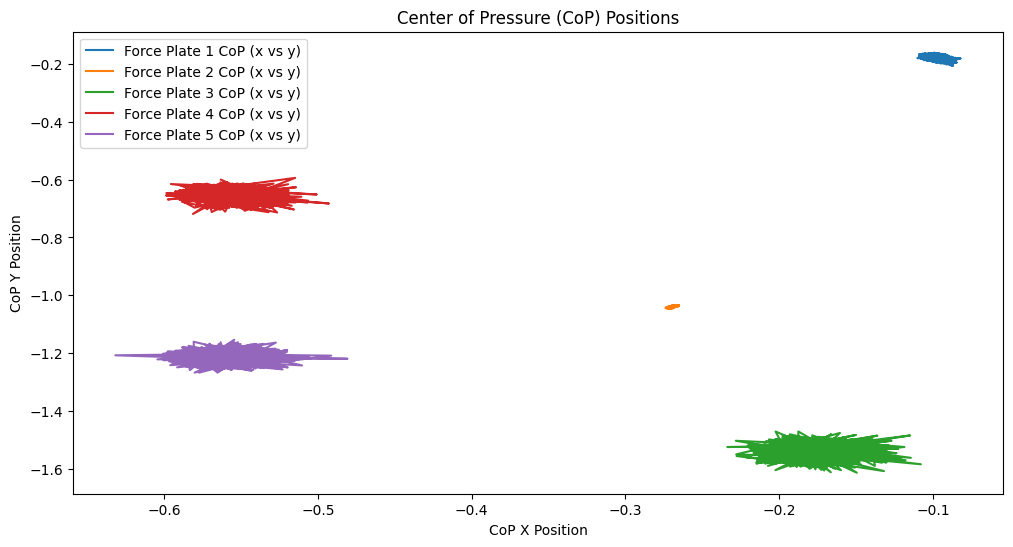

In [5]:
import matplotlib.pyplot as plt

# Plot the vertical GRF (z-component) for both force plates
plt.figure(figsize=(12, 6))
for plate in range(cop.shape[1]):
    plt.plot(cop[:, plate, 0], cop[:, plate, 1], label=f'Force Plate {plate+1} CoP (x vs y)')
plt.xlabel('CoP X Position')
plt.ylabel('CoP Y Position')
plt.title('Center of Pressure (CoP) Positions')
plt.legend()
plt.show()

In [6]:
import ezc3d
c3d = ezc3d.c3d("data/Jeonghan Yoga/Novices/N001/Revolved_Triangle.c3d")
    
# Extract points data: shape (4, 99, framecount)
points = c3d['data']['points']
marker_positions = points[:3, :, :]  # (3, 99, framecount) ignore the 4th dimension (all 1's)

# Transpose to get (framecount, 99, 3)
marker_positions = marker_positions.transpose(2, 1, 0)

In [25]:
import pandas as pd
import numpy as np

def load_data_jeonghan(csv_path):
    """
    Load ground reaction force data from the first block of a CSV file.
    
    Args:
        csv_path (str): Path to the CSV file
        
    Returns:
        tuple: (cop, grf) arrays each with shape [frames, 2 plates, 3 coordinates]
    """
    # Read the file skipping the first 5 rows (header rows)
    yoga_data = pd.read_csv(csv_path, skiprows=5)
    
    # Extract the first trial/block based on the value in the second column
    nan_row_idx = yoga_data.index[yoga_data.iloc[:, 1:].isna().all(axis=1)]
    grf_data = yoga_data.loc[:nan_row_idx[0]-1]
    
    # Extract the needed columns (12 columns total, 6 for each force plate)
    fp1_force = grf_data.iloc[:, 2:5].to_numpy()    # 3 columns for force plate 1 force
    fp1_cop = grf_data.iloc[:, 8:11].to_numpy()     # 3 columns for force plate 1 CoP
    fp2_force = grf_data.iloc[:, 11:14].to_numpy()  # 3 columns for force plate 2 force
    fp2_cop = grf_data.iloc[:, 17:20].to_numpy()    # 3 columns for force plate 2 CoP

    grf = np.stack([fp1_force, fp2_force], axis=1)
    cop = np.stack([fp1_cop, fp2_cop], axis=1) 

    # Find where the marker trajectory data startsgra
    traj_idx = yoga_data.index[yoga_data.iloc[:, 0] == "Trajectories"][0]
    marker_start_idx = traj_idx + 5  # Skip 5 rows after "Trajectories"
    
    # Extract marker data from this point on
    marker_data = yoga_data.iloc[marker_start_idx:]
    # Drop the first 2 columns of marker_data
    marker_clouds = marker_data.iloc[:, 2:]
    # Convert marker data to numpy array and reshape it to [frames, num_markers, 3]
    num_markers = marker_clouds.shape[1] // 3
    marker_clouds = marker_clouds.iloc[:, :num_markers*3].to_numpy().reshape(marker_clouds.shape[0], num_markers, 3)

    return cop.astype(np.float64)/1000, -1*grf.astype(np.float64), marker_clouds

cop, grf, marker_clouds = load_data_jeonghan("data/Jeonghan Yoga/Novices/N001/Revolved_Triangle.csv")
subject_weight = 56*9.81  

/tmp/ipykernel_154897/745019509.py:15: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175) have mixed types. Specify dtype option on import or set low_memory=False.
  yoga_data = pd.read_csv(csv_path, skiprows=5)


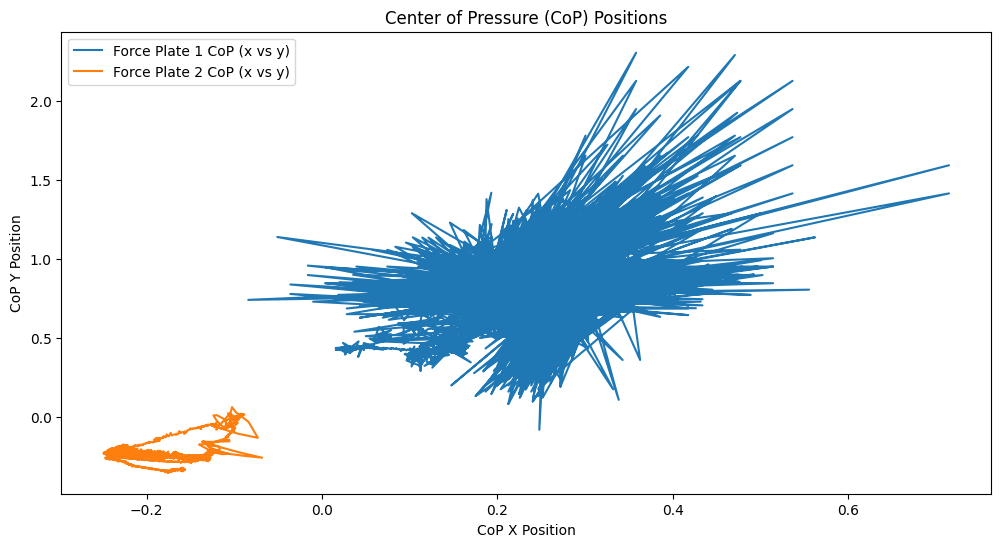

In [26]:
import matplotlib.pyplot as plt

# Plot the vertical GRF (z-component) for both force plates
plt.figure(figsize=(12, 6))
for plate in range(cop.shape[1]):
    plt.plot(cop[:, plate, 0], cop[:, plate, 1], label=f'Force Plate {plate+1} CoP (x vs y)')
plt.xlabel('CoP X Position')
plt.ylabel('CoP Y Position')
plt.title('Center of Pressure (CoP) Positions')
plt.legend()
plt.show()

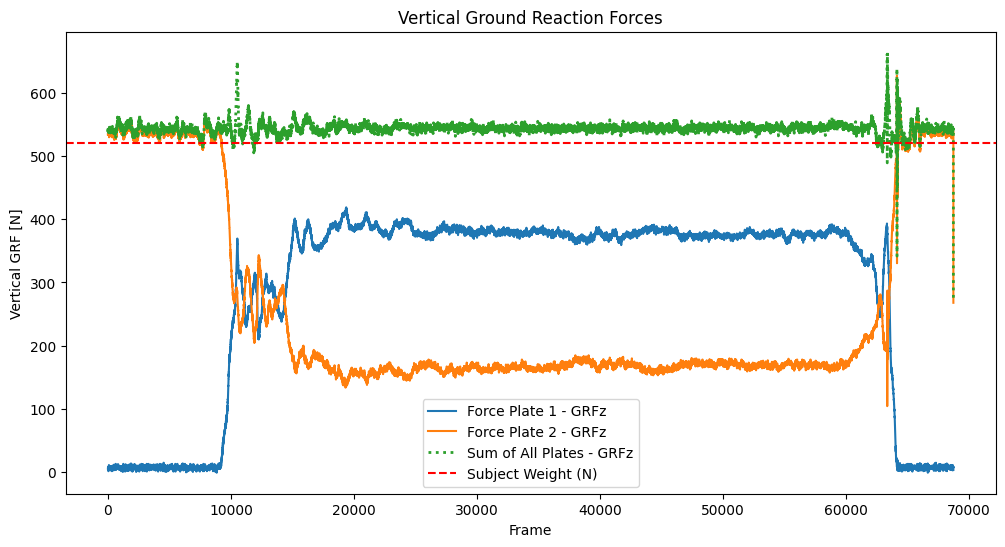

In [27]:
import matplotlib.pyplot as plt

# Plot the vertical GRF (z-component) for both force plates
plt.figure(figsize=(12, 6))
for plate in range(grf.shape[1]):
    plt.plot(grf[:, plate, 2], label=f'Force Plate {plate+1} - GRFz')
plt.plot(np.sum(grf[:, :, 2], axis=1), label='Sum of All Plates - GRFz', linewidth=2, linestyle=':')
plt.axhline(subject.getMassKg() * 9.81, color='red', linestyle='--', label='Subject Weight (N)')
plt.xlabel('Frame')
plt.ylabel('Vertical GRF [N]')
plt.title('Vertical Ground Reaction Forces')
plt.legend()
plt.show()

In [28]:
marker_clouds.shape

(3437, 85, 3)